In [14]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

#Import data
data=pd.read_csv("Cleaned_Form_Responses.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            312 non-null    int64  
 1   Gender                         312 non-null    int64  
 2   Current_Level_of_Studies       312 non-null    int64  
 3   Field_of_Study                 312 non-null    int64  
 4   Type_of_Institution            312 non-null    int64  
 5   Academic_Satisfaction          312 non-null    int64  
 6   Study_Hours_Per_Week           312 non-null    int64  
 7   Academic_Engagement            312 non-null    int64  
 8   Academic_Workload              312 non-null    int64  
 9   Coursework_Pressure            312 non-null    int64  
 10  Academic_Performance           312 non-null    int64  
 11  Sleep_Hours_Per_Night          312 non-null    float64
 12  Eating_Nutrition_Habits        312 non-null    int

# Data Splitting

In [15]:
from sklearn.model_selection import train_test_split

# Drop all columns that are the target or derived from i 
X = data.drop(['Depressed_Anxious'], axis=1)
# Target variable: binned numeric version
y = data['Depressed_Anxious']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, random_state = 42)

print("Training Set:", X_train.shape, y_train.shape)
print("Testing Set:", X_test.shape, y_test.shape)


Training Set: (218, 21) (218,)
Testing Set: (94, 21) (94,)


# Resampling

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

print("Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_res))


Before SMOTE: Counter({1: 146, 2: 39, 3: 33})
After SMOTE: Counter({1: 146, 2: 146, 3: 146})


# Model Training Using SMOTE_Resampled Training Data

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Define all 9 models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gaussian Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Neural Network (MLP)": MLPClassifier(max_iter=1000, random_state=42)
}

# Train all models on SMOTE-resampled data
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    print(f"{name} trained successfully using SMOTE-resampled training data.")
    


Logistic Regression trained successfully using SMOTE-resampled training data.
Decision Tree trained successfully using SMOTE-resampled training data.
Support Vector Machine trained successfully using SMOTE-resampled training data.
K-Nearest Neighbors trained successfully using SMOTE-resampled training data.
Gaussian Naive Bayes trained successfully using SMOTE-resampled training data.
Random Forest trained successfully using SMOTE-resampled training data.
Gradient Boosting trained successfully using SMOTE-resampled training data.
AdaBoost trained successfully using SMOTE-resampled training data.
Neural Network (MLP) trained successfully using SMOTE-resampled training data.


# Model Evaluation Metrics

In [18]:
# Predict on the original test dataset
predictions = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

results = {}

for model_name, y_pred in predictions.items():
    results[model_name] = evaluate_model(y_test, y_pred)

results_df = pd.DataFrame(
    results,
    index=["Accuracy", "Precision", "Recall", "F1 Score"]
).T.sort_values(by="Accuracy", ascending=False)

results_df = results_df.round(2)
print(results_df)



                        Accuracy  Precision  Recall  F1 Score
Random Forest               0.72       0.74    0.72      0.73
Gradient Boosting           0.68       0.69    0.68      0.68
Logistic Regression         0.64       0.72    0.64      0.67
K-Nearest Neighbors         0.60       0.74    0.60      0.62
Neural Network (MLP)        0.60       0.74    0.60      0.63
Gaussian Naive Bayes        0.56       0.70    0.56      0.61
Support Vector Machine      0.54       0.71    0.54      0.58
AdaBoost                    0.54       0.70    0.54      0.60
Decision Tree               0.53       0.62    0.53      0.56


# KFold Cross-Validation

In [20]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tabulate import tabulate

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Gaussian NB": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "MLP": MLPClassifier(max_iter=1000, random_state=42)  # increased max_iter
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Multiclass-safe scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# Cross Validation with SMOTE
results = []
for name, model in models.items():
    steps = [('smote', SMOTE(random_state=42))]
    
    # Scale only for models that need it
    if name in ["Logistic Regression", "Support Vector Machine", "KNN", "MLP"]:
        steps.append(('scaler', StandardScaler()))
    
    steps.append(('model', model))
    pipeline = Pipeline(steps)
    scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring, return_train_score=False)
    results.append({"Model": name, "Accuracy": scores['test_accuracy'].mean(), "Precision": scores['test_precision'].mean(),
        "Recall": scores['test_recall'].mean(),"F1 Score": scores['test_f1'].mean()})

summary_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

print("\n=== CROSS VALIDATION SUMMARY ===")
print(summary_df.round(4))

summary_table = tabulate( summary_df.round(4),headers="keys", tablefmt="fancy_grid", showindex=False, floatfmt=".4f")
print(summary_table)

top_models = summary_df['Model'].head(2).tolist()
worst_models = summary_df['Model'].tail(2).tolist()

print("\nTop 2 Models:")
print(top_models)
print("\nWorst 2 Models:")
print(worst_models)


=== CROSS VALIDATION SUMMARY ===
                    Model  Accuracy  Precision  Recall  F1 Score
5           Random Forest    0.7178     0.5904  0.5639    0.5553
6       Gradient Boosting    0.6445     0.4596  0.4643    0.4547
7                AdaBoost    0.6313     0.5090  0.5343    0.5106
8                     MLP    0.6182     0.4701  0.4680    0.4610
2  Support Vector Machine    0.6088     0.4278  0.4369    0.4246
0     Logistic Regression    0.5958     0.4662  0.4832    0.4581
1           Decision Tree    0.5900     0.4847  0.4726    0.4626
4             Gaussian NB    0.5484     0.4342  0.4625    0.4303
3                     KNN    0.4900     0.4217  0.4057    0.3926
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model                  │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Random Forest          │     0.7178 │      0.5904 │   0.5639 │     0.5553 │
├───

# Feature Importance

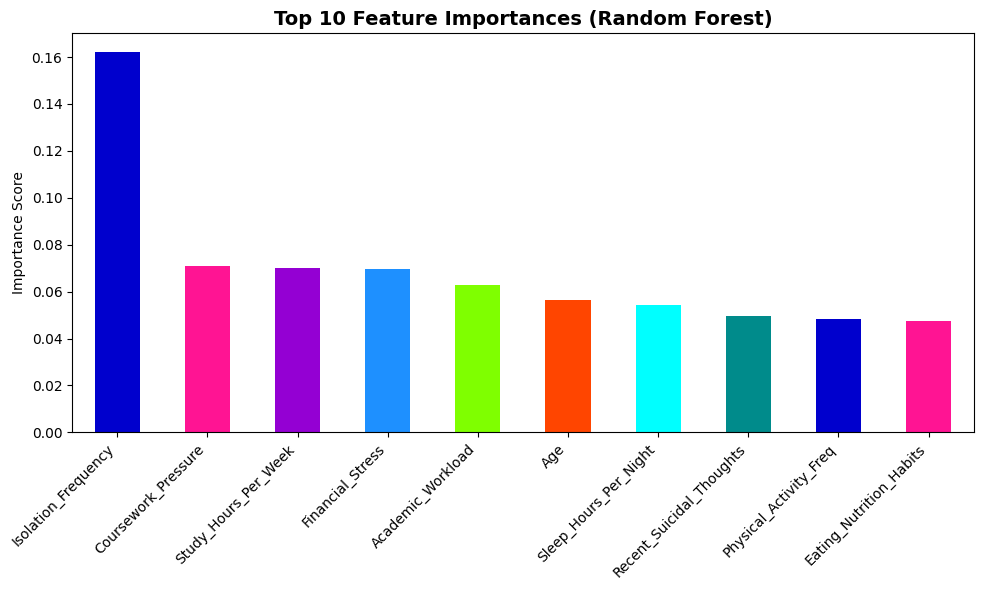

Isolation_Frequency         0.162024
Coursework_Pressure         0.071116
Study_Hours_Per_Week        0.070158
Financial_Stress            0.069618
Academic_Workload           0.063017
Age                         0.056349
Sleep_Hours_Per_Night       0.054440
Recent_Suicidal_Thoughts    0.049810
Physical_Activity_Freq      0.048419
Eating_Nutrition_Habits     0.047614
dtype: float64


In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Train model ---
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

# --- Feature Importance ---
importances = pd.Series(forest.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# --- Plot ---
colors = ['mediumblue', 'deeppink', 'darkviolet', 'dodgerblue', 'chartreuse', 
          'orangered', 'aqua', 'darkcyan', 'mediumblue', 'deeppink']  # Cycle colors

plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='bar', color=colors)
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=14, fontweight='bold')
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Print ---
print(importances.head(10))

In [22]:
#Save Top Features to a List
top_features = importances.head(8).index.tolist()
print("Top 8 Features:", top_features)

# Define features and target
X_top = data[top_features]
y_top = data["Depressed_Anxious"]

Top 8 Features: ['Isolation_Frequency', 'Coursework_Pressure', 'Study_Hours_Per_Week', 'Financial_Stress', 'Academic_Workload', 'Age', 'Sleep_Hours_Per_Night', 'Recent_Suicidal_Thoughts']


# Top Feature ReRun

In [23]:
# Split data into train and test
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, train_size=0.70, random_state=42)

In [24]:
smote = SMOTE(random_state=42)
X_train_top_res, y_train_top_res = smote.fit_resample(
    X_train_top, y_train_top
)

In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# ==========================================
# 1) Use ONLY the top features as X
# ==========================================
# top_features already defined earlier, e.g.:
# top_features = importances.head(8).index.tolist()

X_top = data[top_features]
y_top = data["Depressed_Anxious"]   # or 'Outcome' for diabetes dataset

# ==========================================
# 2) Stratified K-Fold + scoring
# ==========================================
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

# ==========================================
# 3) Only Random Forest & Gradient Boosting
# ==========================================
models_top = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, model in models_top.items():
    # Trees → no scaling needed; just SMOTE + model
    steps = [
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ]
    pipe = Pipeline(steps)

    cv_results = cross_validate(
        pipe,
        X_top, y_top,
        cv=skf,
        scoring=scoring,
        return_train_score=False
    )

    results.append({
        "Model": name,
        "Accuracy":  cv_results['test_accuracy'].mean(),
        "Precision": cv_results['test_precision'].mean(),
        "Recall":    cv_results['test_recall'].mean(),
        "F1 Score":  cv_results['test_f1'].mean()
    })

# ==========================================
# 4) Summary table (CV + SMOTE using TOP features)
# ==========================================
summary_top_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

print("\n=== CV + SMOTE (Top Features Only) ===")
print(summary_top_df.round(2))



=== CV + SMOTE (Top Features Only) ===
               Model  Accuracy  Precision  Recall  F1 Score
0      Random Forest      0.70       0.55    0.57      0.55
1  Gradient Boosting      0.68       0.55    0.55      0.53


# Final Model Evaluation Metrics

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# ============================================================
# Random Forest: CV + SMOTE (TOP FEATURES ONLY)
# ============================================================
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

y_pred_rf_cv = cross_val_predict(rf_pipeline, X_top, y, cv=skf)

print("\nRandom Forest Confusion Matrix (CV + SMOTE + Top Features Only):")
print(confusion_matrix(y, y_pred_rf_cv))

print("\nRandom Forest Classification Report (CV + SMOTE + Top Features Only):")
print(classification_report(y, y_pred_rf_cv))

rf_acc = accuracy_score(y, y_pred_rf_cv)
print(f"Random Forest Accuracy (CV-based, Top Features Only): {rf_acc * 100:.0f}%")

# ============================================================
# Gradient Boosting: CV + SMOTE (TOP FEATURES ONLY)
# ============================================================
gb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', GradientBoostingClassifier(
        random_state=42
    ))
])

y_pred_gb_cv = cross_val_predict(gb_pipeline, X_top, y, cv=skf)

print("\n\nGradient Boosting Confusion Matrix (CV + SMOTE + Top Features Only):")
print(confusion_matrix(y, y_pred_gb_cv))

print("\nGradient Boosting Classification Report (CV + SMOTE + Top Features Only):")
print(classification_report(y, y_pred_gb_cv))

gb_acc = accuracy_score(y, y_pred_gb_cv)
print(f"Gradient Boosting Accuracy (CV-based, Top Features Only): {gb_acc * 100:.0f}%")



Random Forest Confusion Matrix (CV + SMOTE + Top Features Only):
[[176  22  14]
 [ 17  13  23]
 [  9   8  30]]

Random Forest Classification Report (CV + SMOTE + Top Features Only):
              precision    recall  f1-score   support

           1       0.87      0.83      0.85       212
           2       0.30      0.25      0.27        53
           3       0.45      0.64      0.53        47

    accuracy                           0.70       312
   macro avg       0.54      0.57      0.55       312
weighted avg       0.71      0.70      0.70       312

Random Forest Accuracy (CV-based, Top Features Only): 70%


Gradient Boosting Confusion Matrix (CV + SMOTE + Top Features Only):
[[170  26  16]
 [ 19  13  21]
 [ 11   8  28]]

Gradient Boosting Classification Report (CV + SMOTE + Top Features Only):
              precision    recall  f1-score   support

           1       0.85      0.80      0.83       212
           2       0.28      0.25      0.26        53
           3       0.43